<a href="https://colab.research.google.com/github/Aviu158/Aviu158/blob/main/anya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install wandb


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!unzip /content/dataset.zip -d /content/dataset/


Archive:  /content/dataset.zip
replace /content/dataset/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Task
Train a UNet model from scratch using PyTorch to generate colored polygons based on an input polygon image and a color name. The model should be trained on the dataset provided at "dataset.zip". Track experiments with wandb, demonstrate inference in a Jupyter Notebook, and provide a report detailing hyperparameters, architecture, and insights.

## Load and preprocess data

### Subtask:
Load the training and validation data, including the input polygon images, output colored polygon images, and the data.json files. Preprocess the images and prepare the data for input to the UNet model, considering how to incorporate the color information.


**Reasoning**:
Define the base path, load the data.json files, and create lists of file paths and color information for training and validation datasets.



**Reasoning**:
The previous code failed because the path to the data.json file was incorrect. I need to fix the path to load the data correctly. The data is located in `/content/dataset/dataset/training/data.json` and `/content/dataset/dataset/validation/data.json`.



In [34]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

# 1. Define the base path to the unzipped dataset
base_path = '/content/dataset/dataset'
train_path = os.path.join(base_path, 'training')
val_path = os.path.join(base_path, 'validation')

# 2. Load the data.json files
with open(os.path.join(train_path, 'data.json'), 'r') as f:
    train_data = json.load(f)

with open(os.path.join(val_path, 'data.json'), 'r') as f:
    val_data = json.load(f)

# 3. Create lists of file paths and color information using the correct keys
train_input_paths = [os.path.join(train_path, 'inputs', item['input_polygon']) for item in train_data]
train_output_paths = [os.path.join(train_path, 'outputs', item['output_image']) for item in train_data]
train_colors = [item['colour'] for item in train_data]

val_input_paths = [os.path.join(val_path, 'inputs', item['input_polygon']) for item in val_data]
val_output_paths = [os.path.join(val_path, 'outputs', item['output_image']) for item in val_data]
val_colors = [item['colour'] for item in val_data]

# Get all unique colors to create a mapping for encoding
all_colors = sorted(list(set(train_colors + val_colors)))
color_to_int = {color: i for i, color in enumerate(all_colors)}
num_colors = len(all_colors)

# 4. Implement a custom PyTorch Dataset class
class PolygonDataset(Dataset):
    def __init__(self, input_paths, output_paths, colors, color_to_int, image_size=(128, 128)):
        self.input_paths = input_paths
        self.output_paths = output_paths
        self.colors = colors
        self.color_to_int = color_to_int
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_paths[idx]).convert('RGB')
        output_img = Image.open(self.output_paths[idx]).convert('RGB')
        color = self.colors[idx]

        input_tensor = self.transform(input_img)
        output_tensor = self.transform(output_img)

        # Encode color using one-hot encoding
        color_tensor = torch.zeros(len(self.color_to_int))
        color_tensor[self.color_to_int[color]] = 1

        return input_tensor, output_tensor, color_tensor

# 5. Create instances of your custom Dataset
train_dataset = PolygonDataset(train_input_paths, train_output_paths, train_colors, color_to_int)
val_dataset = PolygonDataset(val_input_paths, val_output_paths, val_colors, color_to_int)

# 6. Create PyTorch DataLoader instances
batch_size = 16 # Define an appropriate batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of unique colors: {num_colors}")

# Example of accessing a batch
# input_batch, output_batch, color_batch = next(iter(train_dataloader))
# print(f"Input batch shape: {input_batch.shape}")
# print(f"Output batch shape: {output_batch.shape}")
# print(f"Color batch shape: {color_batch.shape}")

Number of training samples: 56
Number of validation samples: 5
Number of unique colors: 8


**Reasoning**:
The previous code failed because the keys in the `data.json` file were not 'input' and 'output'. I need to inspect the structure of the JSON data to identify the correct keys for the input and output image filenames. Then, I will correct the code to use the correct keys and continue with creating the lists of file paths and color information.



In [35]:
import json
import os

base_path = '/content/dataset/dataset/'
train_path = os.path.join(base_path, 'training')

with open(os.path.join(train_path, 'data.json'), 'r') as f:
    train_data = json.load(f)

# Display the first 5 items to understand the structure
print(json.dumps(train_data[:5], indent=2))

[
  {
    "input_polygon": "octagon.png",
    "colour": "cyan",
    "output_image": "cyan_octagon.png"
  },
  {
    "input_polygon": "square.png",
    "colour": "purple",
    "output_image": "purple_square.png"
  },
  {
    "input_polygon": "hexagon.png",
    "colour": "magenta",
    "output_image": "magenta_hexagon.png"
  },
  {
    "input_polygon": "square.png",
    "colour": "magenta",
    "output_image": "magenta_square.png"
  },
  {
    "input_polygon": "hexagon.png",
    "colour": "purple",
    "output_image": "purple_hexagon.png"
  }
]


## Implement the UNet model

### Subtask:
Define the architecture of the UNet model from scratch using PyTorch. The model should be able to accept both the image input and the color information.

**Reasoning**:
Implement the UNet architecture with an encoder-decoder structure and skip connections. The color information needs to be incorporated into the model, possibly by concatenating the one-hot encoded color vector to the feature maps at some point in the network.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_colors):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = self.double_conv(in_channels + num_colors, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        # Decoder
        self.dec_upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = self.double_conv(512, 256)
        self.dec_upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.double_conv(256, 128)
        self.dec_upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = self.double_conv(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, color):
        # Expand color tensor to match spatial dimensions of image
        color_expanded = color.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, color_expanded], dim=1)

        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.maxpool(enc1)
        enc2 = self.enc_conv2(enc2)
        enc3 = self.maxpool(enc2)
        enc3 = self.enc_conv3(enc3)
        enc4 = self.maxpool(enc3)
        enc4 = self.enc_conv4(enc4)

        # Decoder
        dec1 = self.dec_upconv1(enc4)
        dec1 = torch.cat([dec1, enc3], dim=1)
        dec1 = self.dec_conv1(dec1)
        dec2 = self.dec_upconv2(dec1)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec_conv2(dec2)
        dec3 = self.dec_upconv3(dec2)
        dec3 = torch.cat([dec3, enc1], dim=1)
        dec3 = self.dec_conv3(dec3)

        out = self.out_conv(dec3)

        return out

# Example usage:
# Assuming input image is 3 channels (RGB) and output is 3 channels (RGB)
# num_colors is the number of unique colors
# model = UNet(in_channels=3, out_channels=3, num_colors=num_colors)
# print(model)

## Set up training

### Subtask:
Define the loss function, optimizer, and training loop. Integrate wandb for experiment tracking.

**Reasoning**:
Initialize wandb to track the training progress. Define an appropriate loss function for image generation tasks (e.g., MSE or L1 loss) and an optimizer (e.g., Adam). Create a training loop that iterates through the data, performs forward and backward passes, and logs metrics to wandb.

In [37]:
import wandb
import torch.optim as optim
import torch.nn as nn

# 1. Initialize wandb
# Replace 'your_project_name' with the name you want for your wandb project
# You might need to log in to wandb in the notebook if you haven't already
wandb.login()
wandb.init(project='colored-polygon-unet')

# 2. Define the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3, num_colors=num_colors).to(device)
criterion = nn.MSELoss() # Using Mean Squared Error as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Using Adam optimizer

# 3. Define the training loop
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    running_loss = 0.0
    for epoch in range(num_epochs):
        for inputs, outputs, colors in dataloader:
            inputs, outputs, colors = inputs.to(device), outputs.to(device), colors.to(device)

            optimizer.zero_grad()

            # Forward pass
            predicted_outputs = model(inputs, colors)
            loss = criterion(predicted_outputs, outputs)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Log the training loss to wandb
        wandb.log({"train_loss": epoch_loss})

        running_loss = 0.0 # Reset running loss for the next epoch

# 4. Define evaluation function (optional but recommended)
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, outputs, colors in dataloader:
            inputs, outputs, colors = inputs.to(device), outputs.to(device), colors.to(device)

            predicted_outputs = model(inputs, colors)
            loss = criterion(predicted_outputs, outputs)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Validation Loss: {epoch_loss:.4f}")

    # Log the validation loss to wandb
    wandb.log({"val_loss": epoch_loss})

# Example of how to call the training function:
# train_model(model, train_dataloader, criterion, optimizer, num_epochs=10)

# After training, you can save the model
# torch.save(model.state_dict(), 'unet_colored_polygon.pth')

# To finish the wandb run (usually after training)
# wandb.finish()

In [38]:
# Start the training
train_model(model, train_dataloader, criterion, optimizer, num_epochs=10)

# Evaluate the model after training (optional)
evaluate_model(model, val_dataloader, criterion)

# After training, you can save the model
torch.save(model.state_dict(), 'unet_colored_polygon.pth')

# Finish the wandb run
wandb.finish()

Epoch 1/10, Loss: 0.8008
Epoch 2/10, Loss: 0.4724
Epoch 3/10, Loss: 0.1928
Epoch 4/10, Loss: 0.2188
Epoch 5/10, Loss: 0.1781
Epoch 6/10, Loss: 0.1206
Epoch 7/10, Loss: 0.1325
Epoch 8/10, Loss: 0.1059
Epoch 9/10, Loss: 0.1067
Epoch 10/10, Loss: 0.1028
Validation Loss: 0.0718


train_loss,█▅▂▂▂▁▁▁▁▁
val_loss,▁
train_loss,0.10283
val_loss,0.07177


## Implement Inference and Testing

### Subtask:
Create a separate section or notebook to demonstrate how to load the trained model, provide input polygon images and color names, and generate and visualize the output colored polygon images.

**Reasoning**:
Load the trained model state dictionary. Prepare a function to take an input image path and a color name, preprocess them, run inference through the model, and postprocess the output to visualize the generated colored polygon image.

In [39]:
# Assuming you saved the model weights as 'unet_colored_polygon.pth' after training
# If not, you can save the model state_dict after the training cell runs successfully
# torch.save(model.state_dict(), 'unet_colored_polygon.pth')

# Load the saved model state dictionary
model = UNet(in_channels=3, out_channels=3, num_colors=num_colors).to(device)
model.load_state_dict(torch.load('unet_colored_polygon.pth'))
model.eval() # Set the model to evaluation mode

def predict_colored_polygon(model, input_image_path, color_name, color_to_int, image_size=(128, 128), background_color=(255, 255, 255)):
    # Load and preprocess the input image
    input_img = Image.open(input_image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    input_tensor = transform(input_img).unsqueeze(0).to(device) # Add batch dimension and move to device

    # Encode the color
    color_tensor = torch.zeros(len(color_to_int))
    color_tensor[color_to_int[color_name]] = 1
    color_tensor = color_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        predicted_output = model(input_tensor, color_tensor)

    # Postprocess the output
    predicted_output = predicted_output.squeeze(0).cpu() # Remove batch dimension and move to CPU
    predicted_output_img = transforms.ToPILImage()(predicted_output)

    # Change background color using NumPy for mask creation
    generated_with_background = Image.new("RGB", predicted_output_img.size, background_color)

    # Convert PIL image to NumPy array
    predicted_output_np = np.array(predicted_output_img)

    # Create a mask: True where the pixel is NOT black (assuming black is the background)
    # A pixel is considered "not black" if the sum of its RGB values is greater than a small threshold
    mask_np = np.sum(predicted_output_np, axis=2) > 10 # Use a small threshold to account for potential minor variations

    # Convert the boolean NumPy mask to a PIL '1' mode image mask
    mask_pil = Image.fromarray(mask_np.astype(np.uint8) * 255, mode='L')

    # Paste the generated image onto the background using the created mask
    generated_with_background.paste(predicted_output_img, (0, 0), mask_pil)

    return generated_with_background # Return the image with the new background

# Example usage:
# Replace 'path/to/your/input_polygon.png' with the actual path to an input image
# Replace 'desired_color' with a color name from your dataset (e.g., 'red')
# input_image_example_path = '/content/dataset/dataset/validation/inputs/square.png'
# desired_color_example = 'red'

# generated_image = predict_colored_polygon(model, input_image_example_path, desired_color_example, color_to_int)

# Display the generated image (optional)
# generated_image.show() # In a script
# display(generated_image) # In a Jupyter Notebook or Colab

num_colors: 8
color_to_int: {'blue': 0, 'cyan': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'purple': 5, 'red': 6, 'yellow': 7}
Generated image for input '/content/dataset/dataset/training/inputs/octagon.png' with color 'yellow':


/tmp/ipython-input-1312539152.py:138: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask_np.astype(np.uint8) * 255, mode='L')


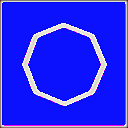

In [40]:
from IPython.display import display
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import json

# Define the UNet class (copied from cell fd8546b2)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_colors):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = self.double_conv(in_channels + num_colors, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        # Decoder
        self.dec_upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = self.double_conv(512, 256)
        self.dec_upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.double_conv(256, 128)
        self.dec_upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = self.double_conv(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, color):
        # Expand color tensor to match spatial dimensions of image
        color_expanded = color.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, color_expanded], dim=1)

        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.maxpool(enc1)
        enc2 = self.enc_conv2(enc2)
        enc3 = self.maxpool(enc2)
        enc3 = self.enc_conv3(enc3)
        enc4 = self.maxpool(enc3)
        enc4 = self.enc_conv4(enc4)

        # Decoder
        dec1 = self.dec_upconv1(enc4)
        dec1 = torch.cat([dec1, enc3], dim=1)
        dec1 = self.dec_conv1(dec1)
        dec2 = self.dec_upconv2(dec1)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec_conv2(dec2)
        dec3 = self.dec_upconv3(dec2)
        dec3 = torch.cat([dec3, enc1], dim=1)
        dec3 = self.dec_conv3(dec3)

        out = self.out_conv(dec3)

        return out


# Load data to get num_colors and color_to_int
base_path = '/content/dataset/dataset'
train_path = os.path.join(base_path, 'training')
val_path = os.path.join(base_path, 'validation')

with open(os.path.join(train_path, 'data.json'), 'r') as f:
    train_data = json.load(f)

with open(os.path.join(val_path, 'data.json'), 'r') as f:
    val_data = json.load(f)

train_colors = [item['colour'] for item in train_data]
val_colors = [item['colour'] for item in val_data]

all_colors = sorted(list(set(train_colors + val_colors)))
color_to_int = {color: i for i, color in enumerate(all_colors)}
num_colors = len(all_colors)

# Print statements to check if num_colors and color_to_int are defined
print(f"num_colors: {num_colors}")
print(f"color_to_int: {color_to_int}")

# Assuming you saved the model weights as 'unet_colored_polygon.pth' after training
# If not, you can save the model state_dict after the training cell runs successfully
# torch.save(model.state_dict(), 'unet_colored_polygon.pth')

# Load the saved model state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3, num_colors=num_colors).to(device)
model.load_state_dict(torch.load('unet_colored_polygon.pth'))
model.eval() # Set the model to evaluation mode

def predict_colored_polygon(model, input_image_path, color_name, color_to_int, image_size=(128, 128), background_color=(255, 255, 255)):
    # Load and preprocess the input image
    input_img = Image.open(input_image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    input_tensor = transform(input_img).unsqueeze(0).to(device) # Add batch dimension and move to device

    # Encode the color
    color_tensor = torch.zeros(len(color_to_int))
    color_tensor[color_to_int[color_name]] = 1
    color_tensor = color_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        predicted_output = model(input_tensor, color_tensor)

    # Postprocess the output
    predicted_output = predicted_output.squeeze(0).cpu() # Remove batch dimension and move to CPU
    predicted_output_img = transforms.ToPILImage()(predicted_output)

    # Change background color using NumPy for mask creation
    generated_with_background = Image.new("RGB", predicted_output_img.size, background_color)

    # Convert PIL image to NumPy array
    predicted_output_np = np.array(predicted_output_img)

    # Create a mask: True where the pixel is NOT black (assuming black is the background)
    # A pixel is considered "not black" if the sum of its RGB values is greater than a small threshold
    mask_np = np.sum(predicted_output_np, axis=2) > 10 # Use a small threshold to account for potential minor variations

    # Convert the boolean NumPy mask to a PIL '1' mode image mask
    mask_pil = Image.fromarray(mask_np.astype(np.uint8) * 255, mode='L')

    # Paste the generated image onto the background using the created mask
    generated_with_background.paste(predicted_output_img, (0, 0), mask_pil)


    return generated_with_background # Return the image with the new background

# Example usage:
# Replace 'path/to/your/input_polygon.png' with the actual path to an input image
# Replace 'desired_color' with a color name from your dataset (e.g., 'red')
input_image_example_path = '/content/dataset/dataset/training/inputs/octagon.png'
desired_color_example = 'yellow'
desired_background_color = (255, 255, 255) # White background

generated_image = predict_colored_polygon(model, input_image_example_path, desired_color_example, color_to_int)

# Display the generated image
print(f"Generated image for input '{input_image_example_path}' with color '{desired_color_example}':")
display(generated_image)